In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,  DataCollatorWithPadding
import torch
from datasets import Dataset, DatasetDict
import pandas as pd
import os
import re
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report

# # new file
# from rules import preprocess_texts, custom_loss, augment_features


In [2]:
# Define the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Llamacha/QuBERTa")
model = AutoModelForSequenceClassification.from_pretrained("Llamacha/QuBERTa", num_labels=24)  # adjust num_labels as necessary


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at Llamacha/QuBERTa and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
def split_document(text, max_length=250, overlap=50):
    # Split text into words
    words = text.split()
    parts = []
    if len(words) <= max_length:
        return [text]  # Return the entire text if it's short enough

    i = 0
    while i < len(words):
        # Ensure that we don't exceed the text length
        end_index = min(i + max_length, len(words))
        # Join the selected range of words back into a string
        chunk_text = " ".join(words[i:end_index])
        parts.append(chunk_text)
        i += (max_length - overlap)
    
    return parts

In [4]:
def remove_numbers(text):
    # Remove numbers using regular expression
    text_without_numbers = re.sub(r'\d+', '', text)
    return text_without_numbers

In [5]:
def load_and_preprocess(directory_paths):
    processed_data = []
    label_dict = {dialect: idx for idx, dialect in enumerate(directory_paths.keys())}
    for dialect, directory_path in directory_paths.items():
        print("dialect: ", dialect)
        for filename in os.listdir(directory_path):
            print("filename: ", filename)
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'r', encoding='latin-1') as file:
                text = file.read().strip()
                text = remove_numbers(text)
                

                # Split document into chunks
                chunks = split_document(text)
                print("document is in ", len(chunks), " chunks")

                # Process each chunk
                for chunk in chunks:
                    # Convert tokens to ids, skipped as tokenizer will handle it
                    # chunk_ids = tokenizer.convert_tokens_to_ids(chunk)
                    
                    # Tokenize text and include attention mask
                    encoded_text = tokenizer(chunk, truncation=True, padding='max_length', max_length=512, return_tensors="pt")
                    # Ensure conversion to list of integers
                    input_ids_list = encoded_text['input_ids'].squeeze(0).tolist()
                    attention_mask_list = encoded_text['attention_mask'].squeeze(0).tolist()
                    processed_data.append({
                        'input_ids': input_ids_list,
                        'attention_mask': attention_mask_list,
                        'labels': label_dict[dialect]
                    })
    return processed_data




In [6]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    input_ids = pad_sequence([torch.tensor(seq) for seq in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence([torch.tensor(mask) for mask in attention_masks], batch_first=True, padding_value=0)
    
    labels = torch.tensor(labels)
    
    return {'input_ids': input_ids, 'attention_mask': attention_masks, 'labels': labels}


In [7]:

# this is for the dialects_mixed_txt

directory_paths = {
    # 'other': '../language_resources/dialects_mixed_txt/other_quechua/',
    'qub': '../language_resources/dialects_mixed_txt/qub',
    'quf': '../language_resources/dialects_mixed_txt/quf',
    'quh': '../language_resources/dialects_mixed_txt/quh',
    'quk': '../language_resources/dialects_mixed_txt/quk',
    'qul': '../language_resources/dialects_mixed_txt/qul',
    'qup': '../language_resources/dialects_mixed_txt/qup',
    'quw': '../language_resources/dialects_mixed_txt/quw',
    'qux': '../language_resources/dialects_mixed_txt/qux',
    'quy': '../language_resources/dialects_mixed_txt/quy',
    'quz': '../language_resources/dialects_mixed_txt/quz', 
    'qvc': '../language_resources/dialects_mixed_txt/qvc',
    'qve': '../language_resources/dialects_mixed_txt/qve',  
    'qvi': '../language_resources/dialects_mixed_txt/qvi',
    'qvm': '../language_resources/dialects_mixed_txt/qvm',
    'qvn': '../language_resources/dialects_mixed_txt/qvn',
    'qvo': '../language_resources/dialects_mixed_txt/qvo',
    'qvw': '../language_resources/dialects_mixed_txt/qvw',
    'qvz': '../language_resources/dialects_mixed_txt/qvz',
    'qwh': '../language_resources/dialects_mixed_txt/qwh',
    'qxl': '../language_resources/dialects_mixed_txt/qxl',
    'qxh': '../language_resources/dialects_mixed_txt/qxh',
    'qxn': '../language_resources/dialects_mixed_txt/qxn',
    'qxo': '../language_resources/dialects_mixed_txt/qxo',
    'qxr': '../language_resources/dialects_mixed_txt/qxr'
    # 'southern': '../language_resources/dialects_mixed_txt/southern_quechua'
}

processed_data = load_and_preprocess(directory_paths)


dialect:  qub
filename:  .DS_Store
document is in  1  chunks
filename:  processed_Huallaga_Huánuco_Quechua_qub.txt
document is in  536  chunks
dialect:  quf
filename:  processed_Lambayeque_Quechua_quf.txt
document is in  734  chunks
dialect:  quh
filename:  MUL028R071I001.txt
document is in  6  chunks
filename:  MUL028R109I001.txt
document is in  6  chunks
filename:  MUL028R061I001.txt
document is in  6  chunks
filename:  MUL028R095I001.txt
document is in  6  chunks
filename:  MUL028R085I001.txt
document is in  10  chunks
filename:  ailla_story_bolivian.txt
document is in  52  chunks
filename:  MUL028R068I001.txt
document is in  6  chunks
filename:  MUL028R110I001.txt
document is in  6  chunks
filename:  MUL028R078I001.txt
document is in  4  chunks
filename:  MUL028R100I001.txt
document is in  6  chunks
filename:  MUL028R101I001.txt
document is in  6  chunks
filename:  MUL028R079I001.txt
document is in  6  chunks
filename:  MUL028R069I001.txt
document is in  6  chunks
filename:  .DS_S

In [8]:
# create the dataset directly from a dictionary
dataset = Dataset.from_dict({'input_ids': [x['input_ids'] for x in processed_data],
                             'attention_mask': [x['attention_mask'] for x in processed_data],
                             'labels': [x['labels'] for x in processed_data]})

# set dataset format for pytorch
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


In [9]:
print(len(processed_data))

22546


In [10]:
# Split the dataset
split_datasets = dataset.train_test_split(test_size=0.15)
train_dataset = split_datasets['train']
val_dataset = split_datasets['test']

In [11]:
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, sampler=train_sampler)


In [12]:
# List to store accuracy per epoch
epoch_accuracy = []
true_labels = []
predicted_labels = []

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    # Extend the global lists
    true_labels.extend(labels.tolist())
    predicted_labels.extend(preds.tolist())
    acc = accuracy_score(labels, preds)
    epoch_accuracy.append(acc)  # Store accuracy
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [13]:
from transformers import get_scheduler

In [14]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,  # Increased epochs
    per_device_train_batch_size=10,  # Slightly larger batch size
    per_device_eval_batch_size=15,
    warmup_steps=500,  # Adjusted warmup steps
    weight_decay=0.01,  # Adjusted weight decay
    # learning_rate=5e-5,  # Added explicit learning rate
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    lr_scheduler_type='cosine',  # Using a cosine learning rate scheduler
    save_strategy="epoch",  # Save the model at each epoch
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="accuracy",
    report_to="tensorboard"  # Ensure metrics are reported to TensorBoard
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [15]:
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3834 [00:00<?, ?it/s]

{'loss': 3.2042, 'grad_norm': 9.349905967712402, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 3.2242, 'grad_norm': 7.970730304718018, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.01}
{'loss': 3.1269, 'grad_norm': 8.760245323181152, 'learning_rate': 3e-06, 'epoch': 0.02}
{'loss': 2.9912, 'grad_norm': 8.212017059326172, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}
{'loss': 2.9709, 'grad_norm': 6.562496662139893, 'learning_rate': 5e-06, 'epoch': 0.03}
{'loss': 2.8811, 'grad_norm': 8.257072448730469, 'learning_rate': 6e-06, 'epoch': 0.03}
{'loss': 2.8125, 'grad_norm': 7.599189281463623, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.8793, 'grad_norm': 9.477469444274902, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.7527, 'grad_norm': 6.17581844329834, 'learning_rate': 9e-06, 'epoch': 0.05}
{'loss': 2.5599, 'grad_norm': 7.518378734588623, 'learning_rate': 1e-05, 'epoch': 0.05}
{'loss': 2.7311, 'grad_norm': 7.9920387

  0%|          | 0/225 [00:00<?, ?it/s]

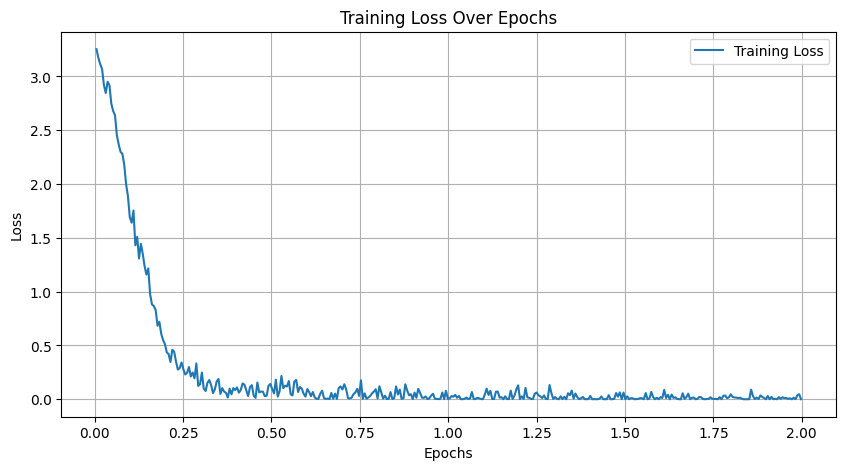

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the validation set
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Plot training loss
training_loss = trainer.state.log_history

epochs = [x['epoch'] for x in training_loss if 'loss' in x]
loss = [x['loss'] for x in training_loss if 'loss' in x]

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/48 [00:00<?, ?it/s]

/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (24).

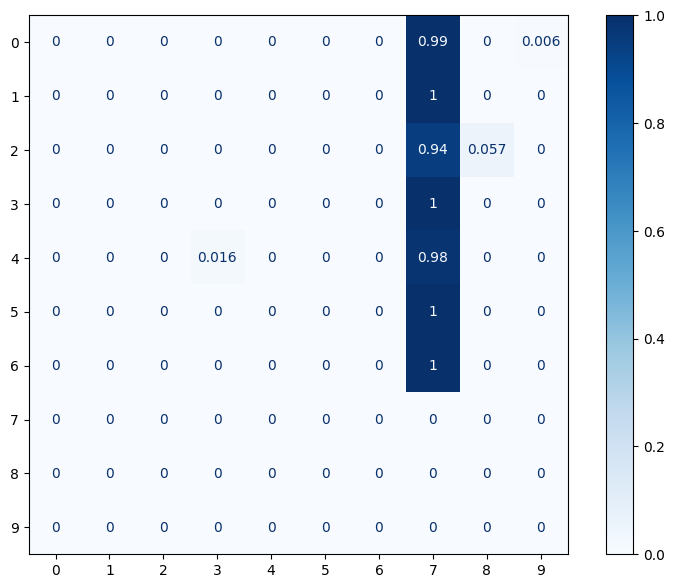

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

directory_paths = {
    # 'other': '../language_resources/dialects_mixed_txt/other_quechua/',
    'qub': '../language_resources/dialects_mixed_txt/qub',
    'quf': '../language_resources/dialects_mixed_txt/quf',
    'quh': '../language_resources/dialects_mixed_txt/quh',
    'quk': '../language_resources/dialects_mixed_txt/quk',
    'qul': '../language_resources/dialects_mixed_txt/qul',
    'qup': '../language_resources/dialects_mixed_txt/qup',
    'quw': '../language_resources/dialects_mixed_txt/quw',
    'qux': '../language_resources/dialects_mixed_txt/qux',
    'quy': '../language_resources/dialects_mixed_txt/quy',
    'quz': '../language_resources/dialects_mixed_txt/quz', 
    'qvc': '../language_resources/dialects_mixed_txt/qvc',
    'qve': '../language_resources/dialects_mixed_txt/qve',  
    'qvi': '../language_resources/dialects_mixed_txt/qvi',
    'qvm': '../language_resources/dialects_mixed_txt/qvm',
    'qvn': '../language_resources/dialects_mixed_txt/qvn',
    'qvo': '../language_resources/dialects_mixed_txt/qvo',
    'qvw': '../language_resources/dialects_mixed_txt/qvw',
    'qvz': '../language_resources/dialects_mixed_txt/qvz',
    'qwh': '../language_resources/dialects_mixed_txt/qwh',
    'qxl': '../language_resources/dialects_mixed_txt/qxl',
    'qxh': '../language_resources/dialects_mixed_txt/qxh',
    'qxn': '../language_resources/dialects_mixed_txt/qxn',
    'qxo': '../language_resources/dialects_mixed_txt/qxo',
    'qxr': '../language_resources/dialects_mixed_txt/qxr'
    # 'southern': '../language_resources/dialects_mixed_txt/southern_quechua'
}

def plot_confusion_matrix(trainer):
    # Get predictions
    predictions, labels, _ = trainer.predict(val_dataset)
    preds_flat = predictions.argmax(-1)
    
    # Compute the confusion matrix
    cm = confusion_matrix(labels, preds_flat, normalize='true')

    # Extract unique labels (sorted by value) to ensure consistent label names
    unique_labels = np.unique(np.concatenate((labels, preds_flat)))
    label_names = [list(directory_paths.keys())[label] for label in unique_labels]

    # # Display the confusion matrix
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    # disp.plot(cmap=plt.cm.Blues)
    # plt.title('Normalized Confusion Matrix')
    # plt.xticks(rotation=45, ha="right")  # Optional: Rotate labels for better visibility
    # plt.xlabel('Predicted Labels')
    # plt.ylabel('True Labels')
    # plt.show()
    # Compute and plot confusion matrix

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    fig, ax = plt.subplots(figsize=(10, 7))  # adjust the size as needed
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title('Normalized Confusion Matrix Neural Classifier')
    plt.xticks(rotation=45, fontsize=12)  # Optionally adjust font size of axis labels and rotate them for better visibility
    plt.yticks(fontsize=12)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()  # Adjust layout

plot_confusion_matrix(trainer)



/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


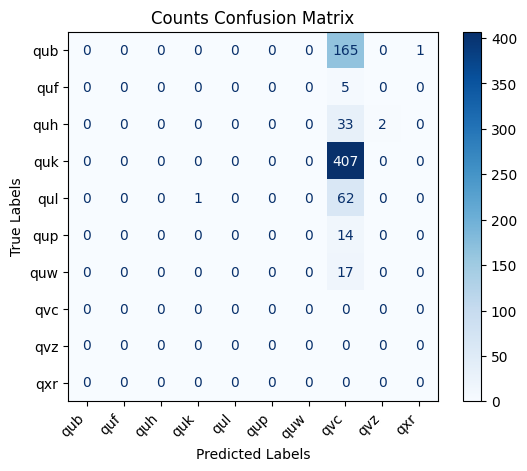

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(trainer):
    # Get predictions
    predictions, labels, _ = trainer.predict(val_dataset)
    preds_flat = predictions.argmax(-1)
    
    # Compute the confusion matrix
    cm = confusion_matrix(labels, preds_flat)

    # Extract unique labels (sorted by value) to ensure consistent label names
    unique_labels = np.unique(np.concatenate((labels, preds_flat)))
    label_names = [list(directory_paths.keys())[label] for label in unique_labels]

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Counts Confusion Matrix')
    plt.xticks(rotation=45, ha="right")  # Optional: Rotate labels for better visibility
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(trainer)



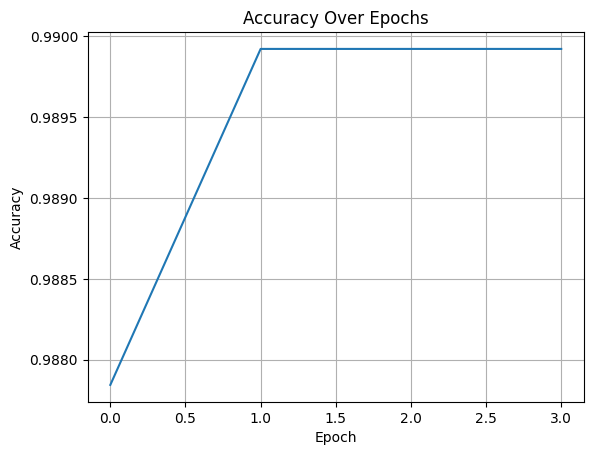

In [ ]:
plt.plot(epoch_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.show()

In [ ]:
def get_predictions(model, dataloader):
    model.eval()  # Put model in evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs = {'input_ids': batch['input_ids'].to(model.device),
                      'attention_mask': batch['attention_mask'].to(model.device)}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    
    return predictions, true_labels

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have a DataLoader for your validation dataset
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)  # Adjust batch size as needed

# Get predictions
predictions, true_labels = get_predictions(model, val_dataloader)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=[label for label in directory_paths.keys()])
print("Classification Report:\n", report)

/var/folders/fs/xcmh2x8j5zdc3l6qxd_9cy7w0000gn/T/ipykernel_31370/64439305.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = pad_sequence([torch.tensor(seq) for seq in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
/var/folders/fs/xcmh2x8j5zdc3l6qxd_9cy7w0000gn/T/ipykernel_31370/64439305.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = pad_sequence([torch.tensor(mask) for mask in attention_masks], batch_first=True, padding_value=0)


Classification Report:
               precision    recall  f1-score   support

         qub       1.00      1.00      1.00        70
         quf       1.00      1.00      1.00       106
         quh       0.95      1.00      0.98       586
         quk       1.00      1.00      1.00       115
         qul       1.00      1.00      1.00        96
         qup       1.00      1.00      1.00       123
         quw       1.00      1.00      1.00        85
         qux       1.00      0.92      0.96        50
         quy       0.99      1.00      1.00       463
         quz       0.98      0.61      0.75        72
         qvc       1.00      1.00      1.00       124
         qve       1.00      1.00      1.00       121
         qvi       1.00      1.00      1.00        98
         qvm       1.00      1.00      1.00        84
         qvn       1.00      1.00      1.00       109
         qvo       1.00      1.00      1.00        78
         qvw       1.00      1.00      1.00        73
   

In [ ]:
dialects_list = [
    'qub', 'quf', 'quh', 'quk', 'qul', 'qup', 'quw', 'qux', 'quy', 'quz',
    'qvc', 'qve', 'qvi', 'qvm', 'qvn', 'qvo', 'qvw', 'qvz', 'qwh', 'qxl',
    'qxh', 'qxn', 'qxo', 'qxr'
]

dialect_indices = [index for index, label in enumerate(directory_paths.keys()) if label in dialects_list]

# Filter the classification report for Bolivian dialects
bolivian_report = classification_report(true_labels, predictions, target_names=[label for label in directory_paths.keys()], labels=dialect_indices)
print("ALL Dialects Classification Report:\n", bolivian_report)

ALL Dialects Classification Report:
               precision    recall  f1-score   support

         qub       1.00      1.00      1.00        70
         quf       1.00      1.00      1.00       106
         quh       0.95      1.00      0.98       586
         quk       1.00      1.00      1.00       115
         qul       1.00      1.00      1.00        96
         qup       1.00      1.00      1.00       123
         quw       1.00      1.00      1.00        85
         qux       1.00      0.92      0.96        50
         quy       0.99      1.00      1.00       463
         quz       0.98      0.61      0.75        72
         qvc       1.00      1.00      1.00       124
         qve       1.00      1.00      1.00       121
         qvi       1.00      1.00      1.00        98
         qvm       1.00      1.00      1.00        84
         qvn       1.00      1.00      1.00       109
         qvo       1.00      1.00      1.00        78
         qvw       1.00      1.00      1.00 

In [25]:
unlabeled = {
    'other': '../language_resources/dialects_mixed_txt/other_quechua/',
    'southern': '../language_resources/dialects_mixed_txt/southern_quechua'
}
unlabeled_processed = load_and_preprocess(unlabeled)

label_dict = {dialect: idx for idx, dialect in enumerate(directory_paths.keys())}


dialect:  other
filename:  .DS_Store
document is in  1  chunks
filename:  qu.txt
document is in  4487  chunks
dialect:  southern
filename:  cosude2009-2011.txt
document is in  33  chunks
filename:  amerindia_1999.txt
document is in  49  chunks
filename:  wikimedia.txt
document is in  21  chunks
filename:  cc100-quechua.txt
document is in  4487  chunks
filename:  gregorio_condori_mamani.txt
document is in  23  chunks
filename:  Lectura-favorita-quechua-cusco-2019.txt
document is in  19  chunks
filename:  normatividad_ana_2013.txt
document is in  117  chunks
filename:  microsoft_2021.txt
document is in  13  chunks
filename:  lecturas-favoritas-quechua-chanka-2019.txt
document is in  19  chunks
filename:  focus_2007.txt
document is in  14  chunks
filename:  poder_jucial_peru.txt
document is in  15  chunks
filename:  acuerdo_nacional_2014.txt
document is in  49  chunks
filename:  unesco_2020.txt
document is in  76  chunks
filename:  tatoeba.txt
document is in  7  chunks
filename:  que_comm

In [26]:
# try to do stuff with unloaded data

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)  # Move model to the appropriate device

def predict(model, dataset):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure the model is on the correct device

    for item in dataset:
        # Extract tensors and move them to the correct device
        input_ids = item['input_ids'].unsqueeze(0).to(device)
        attention_mask = item['attention_mask'].unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            prediction = torch.argmax(outputs.logits, dim=-1)
            predictions.append(prediction.item())

    return predictions


# Convert data into tensors within the dictionary comprehension
dataset = Dataset.from_dict({
    'input_ids': [torch.tensor(x['input_ids']) for x in unlabeled_processed],
    'attention_mask': [torch.tensor(x['attention_mask']) for x in unlabeled_processed]
})

# # Set the dataset format for PyTorch
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])

predictions = predict(model, dataset)

# Map predictions back to dialect labels
dialect_labels = {index: dialect for dialect, index in label_dict.items()}
predicted_dialects = [dialect_labels[pred] for pred in predictions]
print(predicted_dialects)

KeyboardInterrupt: 

In [27]:
import csv

def save_results_to_csv(true_labels, predicted_labels):
    with open('./results/true_vs_predicted.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['True Labels', 'Predicted Labels'])
        for true, predicted in zip(true_labels, predicted_labels):
            writer.writerow([true, predicted])

# Assuming training is done and you've called the appropriate functions
save_results_to_csv(true_labels, predicted_labels)

In [ ]:
# 5-fold cross validation

def train_fold(train_idx, val_idx, model, tokenizer, compute_metrics, fold_number):
    # Creating subsets for training and validation
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)
    
    # Convert to Hugging Face format datasets
    train_dataset = Dataset.from_dict({k: train_subset[k] for k in ['input_ids', 'attention_mask', 'labels']})
    val_dataset = Dataset.from_dict({k: val_subset[k] for k in ['input_ids', 'attention_mask', 'labels']})
    
    # Define Trainer
    training_args.output_dir = f'./results_fold_{fold_number}'  # Change output dir for each fold
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )
    
    # Train the model
    trainer.train()
    return trainer.evaluate()

# Store results from each fold
results = []

for fold_number, (train_idx, val_idx) in enumerate(kfold.split(dataset_list)):
    print(f"Training fold {fold_number+1}/{kfold.n_splits}")
    result = train_fold(train_idx, val_idx, model, tokenizer, compute_metrics, fold_number)
    results.append(result)

# Calculate and print average results across folds
average_accuracy = np.mean([result['eval_accuracy'] for result in results])
print(f"Average Cross-Validation Accuracy: {average_accuracy}")
